### A Simplied Interface to Text Classification With Hugging Face Transformers in TensorFlow Using [ktrain](https://github.com/amaiya/ktrain)

*ktrain* requires TensorFlow 2.

Steps to install ktrain:
- install ktrain - this will remove the current version of sklearn
- uninstall sklearn (old version)
- install sklearn
- restart
- check ktrain version

In [ ]:
import sklearn

sklearn.__version__

'1.0.1'

In [ ]:
!pip install -q ktrain
#!pip uninstall ktrain -y

In [2]:
!pip uninstall scikit-learn -y

Found existing installation: scikit-learn 0.23.2
Uninstalling scikit-learn-0.23.2:
  Successfully uninstalled scikit-learn-0.23.2


In [3]:
!pip install scikit-learn
# reboot

     |████████████████████████████████| 24.8 MB 55.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ktrain 0.28.3 requires scikit-learn==0.23.2, but you have scikit-learn 1.0.2 which is incompatible.


In [1]:
import ktrain
ktrain.__version__

'0.28.3'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
% cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
!pip3 install -q tensorflow

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.7.0


### Load a Dataset Into Arrays

In [ ]:
df = pd.read_csv('wiseworking_aug.csv')
print(df.head())
categories = df['Category'].unique()
categories

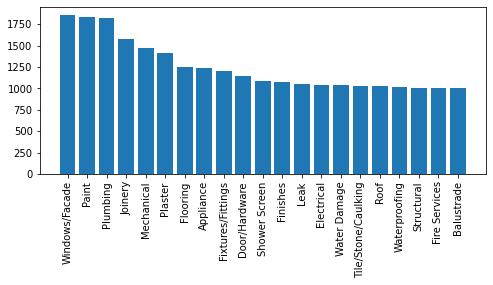

In [ ]:
def plot_data(keys, values, title):
    plt.figure(figsize=(8,4))
    plt.bar(keys, values)
    plt.xticks(rotation=90)
    plt.subplots_adjust(bottom=0.3)
    plt.title = title
    plt.show()

unique_categories_count = df.Category.value_counts()
plot_data(unique_categories_count.index, unique_categories_count.values, 'Category')

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


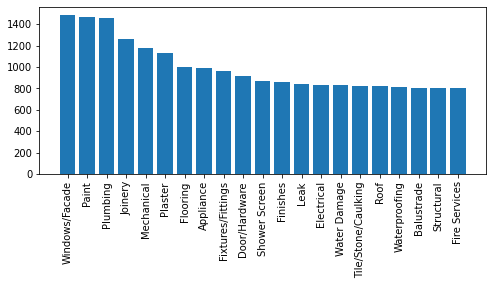

<class 'list'>
<class 'numpy.ndarray'>


In [ ]:
from sklearn.model_selection import train_test_split

X = df[['Description']]
y = df[['Category']]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 1, stratify = df['Category'])

print(type(X_train))
print(type(y_train))

unique_categories_count = y_train.Category.value_counts()
plot_data(unique_categories_count.index, unique_categories_count.values, 'Category')

X_train = X_train.Description.values.tolist()
y_train = y_train.Category.to_numpy()
X_test = X_test.Description.values.tolist()
y_test = y_test.Category.to_numpy()
print(type(X_train))
print(type(y_train))

## STEP 1:  Preprocess Data and Create a Transformer Model

We will use [DistilBERT](https://arxiv.org/abs/1910.01108).

In [ ]:
import ktrain
from ktrain import text

MODEL_NAME = 'distilbert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=500, classes=categories)
trn = t.preprocess_train(X_train, y_train)
val = t.preprocess_test(X_test, y_test)
model = t.get_classifier()

/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:420: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')


preprocessing train...
language: en
train sequence lengths:
	mean : 27
	95percentile : 74
	99percentile : 136


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 26
	95percentile : 74
	99percentile : 135


In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/weights-02.hdf5')

In [ ]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=16)

In [ ]:
# if you want to find learning rate
learner.lr_find(show_plot=True, max_epochs=2)

simulating training for different learning rates... this may take a few moments...
Epoch 1/2
2307/3492 [==================>...........] - ETA: 17:04 - loss: 3.0207 - accuracy: 0.0698

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes = categories, y = y_train)
train_class_weights = dict(enumerate(class_weights))

In [ ]:
# if you want to use autofit
learner.reset_weights(verbose=0)
learner.autofit(0.001, checkpoint_folder='/tmp/buildingDefect')

## STEP 2:  Train the Model

In [5]:
!pwd

/content/drive/MyDrive/Colab Notebooks


In [ ]:
# way 1
num_epochs = 3
learner.fit_onecycle(5e-5, num_epochs, class_weight=train_class_weights, checkpoint_folder='/content/drive/MyDrive/Colab Notebooks')

## STEP 3: Evaluate and Inspect the Model

In [ ]:
# without class_weight
learner.validate(class_names=t.get_classes())

                     precision    recall  f1-score   support

          Appliance       0.87      0.89      0.88       247
         Balustrade       0.99      1.00      1.00       201
      Door/Hardware       0.81      0.79      0.80       229
         Electrical       0.93      0.84      0.88       209
           Finishes       0.82      0.89      0.85       216
      Fire Services       1.00      1.00      1.00       202
  Fixtures/Fittings       0.81      0.80      0.80       240
           Flooring       0.96      0.95      0.95       250
            Joinery       0.89      0.79      0.84       315
               Leak       0.92      0.92      0.92       211
         Mechanical       0.91      0.92      0.91       293
              Paint       0.84      0.85      0.84       368
            Plaster       0.88      0.91      0.89       282
           Plumbing       0.85      0.83      0.84       364
               Roof       1.00      1.00      1.00       205
      Shower Screen    

array([[221,   0,   1,   2,   1,   0,   5,   0,   2,   0,   7,   0,   1,
          3,   0,   0,   0,   0,   0,   0,   4],
       [  0, 201,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0],
       [  2,   0, 180,   2,   2,   0,   2,   1,   3,   0,   2,  16,   3,
          1,   0,   1,   0,   0,   0,   0,  14],
       [  5,   0,   3, 175,   0,   0,   5,   0,   2,   0,  11,   3,   0,
          2,   0,   1,   0,   1,   0,   0,   1],
       [  0,   0,   3,   0, 192,   0,   1,   4,   2,   0,   0,   5,   0,
          2,   0,   1,   0,   4,   0,   0,   2],
       [  0,   0,   0,   0,   0, 201,   0,   0,   0,   0,   0,   1,   0,
          0,   0,   0,   0,   0,   0,   0,   0],
       [  2,   0,   6,   4,   3,   0, 191,   0,   6,   0,   5,   0,   1,
         17,   0,   0,   0,   1,   0,   0,   4],
       [  0,   0,   0,   0,   4,   0,   0, 237,   1,   0,   0,   1,   1,
          0,   0,   0,   1,   3,   0,   0,   2],
       [  7,   1,   9,  

Let's examine the validation example about which we were the most wrong.

In [ ]:
learner.view_top_losses(n=1, preproc=t)

----------
id:879 | loss:11.58 | true:Mechanical | pred:Joinery)



In [ ]:
print(X_test[3])

" Hi, your petition has been forward to Walker Plumbing system who will contact you directly to schedule attendance. " The plumber came this morning on / /, did lots of things, merely was ineffectual to work the job. Please advise the next step, as the matter is urgent.


## STEP 4: Making Predictions on New Data in Deployment

In [ ]:
# get predictor from trained model
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [6]:
# get predictor from saved model
predictor = ktrain.load_predictor('building_defect_predictor')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [7]:
text_to_predict = "There is a problem with the floorboards and there are cracks in the walls."

In [8]:
predictor.predict(text_to_predict)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

'Flooring'

In [27]:
# predicted probability scores for each category
def predict_probability(text_to_predict):
  probs = predictor.predict_proba(text_to_predict)*100
  prob_list = probs.tolist()
  prob_list = [round(val,2) for val in prob_list]
  class_list = predictor.get_classes()
  dic = dict(zip(class_list, prob_list))
  dic = {k: v for k, v in sorted(dic.items(), key=lambda item: item[1], reverse=True)}
  predictions = []
  for key, value in dic.items():
      predictions.append(key + ':' + str(value))
  return predictions

In [16]:
predictions = predict_probability(text_to_predict)
print(predictions)

Flooring  :  89.96
Door/Hardware  :  7.79
Paint  :  0.98
Fixtures/Fittings  :  0.29
Joinery  :  0.26
Windows/Facade  :  0.26
Plumbing  :  0.14
Tile/Stone/Caulking  :  0.1
Electrical  :  0.04
Finishes  :  0.04
Plaster  :  0.04
Appliance  :  0.03
Leak  :  0.02
Mechanical  :  0.02
Shower Screen  :  0.01
Structural  :  0.01
Water Damage  :  0.01
Waterproofing  :  0.01
Balustrade  :  0.0
Fire Services  :  0.0
Roof  :  0.0
['Flooring:89.96', 'Door/Hardware:7.79', 'Paint:0.98', 'Fixtures/Fittings:0.29', 'Joinery:0.26', 'Windows/Facade:0.26', 'Plumbing:0.14', 'Tile/Stone/Caulking:0.1', 'Electrical:0.04', 'Finishes:0.04', 'Plaster:0.04', 'Appliance:0.03', 'Leak:0.02', 'Mechanical:0.02', 'Shower Screen:0.01', 'Structural:0.01', 'Water Damage:0.01', 'Waterproofing:0.01', 'Balustrade:0.0', 'Fire Services:0.0', 'Roof:0.0']


In [ ]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1


In [ ]:
predictor.explain(X_test[3])

/usr/local/lib/python3.7/dist-packages/ktrain/text/predictor.py:124: UserWarning: ktrain requires a forked version of eli5 to support tf.keras. Install with: pip install https://github.com/amaiya/eli5/archive/refs/heads/tfkeras_0_10_1.zip
  warnings.warn(msg)


The words in the darkest shade of green contribute most to the classification and agree with what you would expect for this example.

We can save and reload our predictor for later deployment.

In [ ]:
!pwd

/content/drive/MyDrive/Colab Notebooks


In [ ]:
predictor.save('building_defect_predictor')

**Prediction**

In [17]:
df_predict = pd.read_csv('wiseworking_predict.csv')

In [ ]:
print('Total rows:', len(df_predict))
for index, row in df_predict.iterrows():
  print(index)
  predictions = predict_probability(row['Description'])
  df_predict.loc[index, 'prediction1'] = predictions[0]
  df_predict.loc[index, 'prediction2'] = predictions[1]
  df_predict.loc[index, 'prediction3'] = predictions[2]

df_predict.to_csv('wiseworking_predict.csv', index=False)